In [1]:
using Random, Distributions, Statistics, DataFrames # w terminalu wpisac julia, potem ] i komenda np. add DataFrames

h = 0.1 #storage cost koszt przechowywania (finansowy proporcjonalny to stop procentowy) 
        #dobry do analizy wrazliwosci
c = 2.0 #unit profit  (marza) 
p = 0.50 #probability of delivery (na 50 za 1 dni 25% za 2 dni  )
K = 40 # fixed order cost kierowca chwcyeneie za telefon 
k = 1.0 # variable order cost liczba przewzoych jednostek 
average_demand = 20 

s = 30 #zmienne decyzycjne  s S je mamy znalezc jesli poziom zapasu spadnie do 30 albo mniej to wtedy dobijamy do 50 
S = 50 

X = 100  # poczatek dnia pierwszego symulacji
profit = 0.0 # ktora kazdnego dnia bedziemy dodawac ( to nie jest parametr zmienna stanu)
# wzgledme ktorych robimy analize wrazliwosci 
# trzeba wybrac na wiecej 2 naraz 
#bedziemy szukac s S ktore generuja najwiekszy profit 

0.0

In [2]:
pois = Distributions.Poisson(average_demand)# mozemy wybrac inny rozklad normalny, log wedlugktorego mozna robic analize wraz
rand(pois, 10) # rozklad poosiona ma mala wariacje (popyt jest bardziej chaotyczny)

10-element Vector{Int64}:
 15
 17
 17
 15
 17
 12
 22
 22
 20
 17

In [3]:
normal=Distributions.Normal(20,5)
sprzedaz = round.(Int, rand(normal, 10))
println(sprzedaz)

[16, 15, 21, 23, 22, 12, 17, 11, 28, 17]


In [4]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(average_demand,5)
    for day in 1:m
        if Xⱼ < s
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 1 method)

In [5]:
res = simulateOneRun(20,20,200)

(profit = 602.3, lost_orders = 69.0, warehouse_levels = [100, 84, 59, 38, 200, 180, 158, 134, 118, 107, 88, 70, 53, 36, 23, 0, 0, 0, 200, 181])

In [6]:
@show res.profit
@show res.lost_orders
@show res.warehouse_levels;

res.profit = 602.3
res.lost_orders = 69.0
res.warehouse_levels = [100, 84, 59, 38, 200, 180, 158, 134, 118, 107, 88, 70, 53, 36, 23, 0, 0, 0, 200, 181]


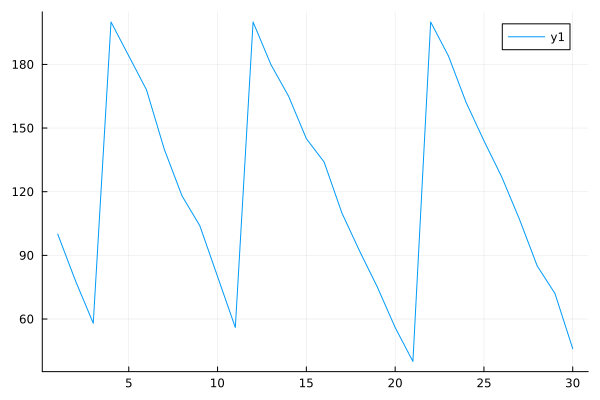

In [7]:
Random.seed!(10)
res = simulateOneRun(30,50,200)

# using PyPlot
# plot(res.warehouse_levels)
# show()
using Plots
plot(res.warehouse_levels)

In [8]:
res = DataFrame(simulateOneRun(9,5,10) for n in 1:4)

Row,profit,lost_orders,warehouse_levels
,Float64,Float64,Array…
1,312.4,61.0,"[100, 81, 68, 44, 29, 10, 0, 0, 0]"
2,180.9,54.0,"[100, 78, 58, 38, 15, 10, 10, 10, 0]"
3,323.5,90.0,"[100, 72, 56, 34, 13, 10, 0, 0, 0]"
4,319.8,61.0,"[100, 74, 59, 39, 30, 10, 0, 10, 0]"


In [9]:

function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end


#run_sims(30,50,100)

run_sims (generic function with 2 methods)

In [10]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,s,S,1000)
    for S in 180:5:350, s in 5:5:50 if S > s ) 

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,5,180,1000,9391.52,331.781,637.637,126.76
2,250,5,185,1000,9413.35,330.116,627.17,127.088
3,250,5,190,1000,9468.49,327.992,605.217,120.83
4,250,5,195,1000,9488.22,330.005,595.627,123.362
5,250,5,200,1000,9516.57,327.227,582.102,121.781
6,250,5,205,1000,9536.62,313.142,572.135,115.821
7,250,5,210,1000,9560.89,328.941,553.099,120.697
8,250,5,215,1000,9556.5,320.331,549.847,117.835
9,250,5,220,1000,9562.11,312.991,539.899,117.828


In [11]:
best_row = argmin(df.lost_mean)

350

In [12]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
350,250,50,350,1000,9260.77,289.952,84.828,64.6009


In [13]:
best_row = argmax(df.profit_mean)

221

In [14]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,9967.95,293.758,206.157,94.4846


In [15]:
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,9967.95,293.758,206.157,94.4846


Zwiekszenie ceny o 5% 
1) podejscie 

In [16]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20,
    price_increase = 0.05)
    
    # Calculate new price
    new_c = c * (1 + price_increase)
    
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(20,5)
    for day in 1:m
        if Xⱼ < s  # reorder point  #100 < 5 
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*new_c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 1 method)

In [17]:

function run_sims(m,s,S,N=100)
    df = DataFrame(simulateOneRun(m,s,S,price_increase=0.05) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end


#run_sims(30,50,100)

run_sims (generic function with 2 methods)

In [18]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,s,S,1000)
    for S in 180:5:350, s in 5:5:50 if S > s )

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,5,180,1000,10264.2,358.547,637.637,126.76
2,250,5,185,1000,10287.6,356.933,627.17,127.088
3,250,5,190,1000,10347.4,353.714,605.217,120.83
4,250,5,195,1000,10369.1,356.029,595.627,123.362
5,250,5,200,1000,10400.5,352.975,582.102,121.781
6,250,5,205,1000,10422.6,337.583,572.135,115.821
7,250,5,210,1000,10449.9,354.982,553.099,120.697
8,250,5,215,1000,10446.1,345.089,549.847,117.835
9,250,5,220,1000,10453.7,337.018,539.899,117.828


In [19]:
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,10927.1,315.016,206.157,94.4846


In [20]:
# tutaj symulacja zwiekszona o te 5% 

In [21]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,s,S,1000)
    for S in 180:5:350, s in 5:5:50 if S > s )

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,5,180,1000,10264.2,358.547,637.637,126.76
2,250,5,185,1000,10287.6,356.933,627.17,127.088
3,250,5,190,1000,10347.4,353.714,605.217,120.83
4,250,5,195,1000,10369.1,356.029,595.627,123.362
5,250,5,200,1000,10400.5,352.975,582.102,121.781
6,250,5,205,1000,10422.6,337.583,572.135,115.821
7,250,5,210,1000,10449.9,354.982,553.099,120.697
8,250,5,215,1000,10446.1,345.089,549.847,117.835
9,250,5,220,1000,10453.7,337.018,539.899,117.828


In [22]:
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
221,250,35,230,1000,10927.1,315.016,206.157,94.4846


o ile musi zmienić się parametr (np. cena produktu)

In [23]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(pr, m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    price_increase = pr
    # Calculate new price
    new_c = c * (1 + price_increase)
    
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(20,5)
    for day in 1:m
        if Xⱼ < s  # reorder point  #100 < 5 
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*new_c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 2 methods)

In [24]:
function run_sims(pr,m,s,S,N=100)
    df = DataFrame(simulateOneRun(pr,m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        p=pr,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end

run_sims (generic function with 3 methods)

In [25]:
# wybralem 35,230 to byly najlepsze parametry (najwiekszy profit)
using Random
Random.seed!(0)
df = DataFrame(run_sims(pr,250,35,230,1000)
    for pr in 0.00:0.01:1.0)

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,250,35,230,1000,0.0,9951.18,287.875,209.203,94.6796
2,250,35,230,1000,0.01,10150.8,294.569,204.686,94.7049
3,250,35,230,1000,0.02,10335.1,291.758,212.174,95.8451
4,250,35,230,1000,0.03,10532.7,312.785,209.304,98.434
5,250,35,230,1000,0.04,10717.0,300.275,210.436,94.4456
6,250,35,230,1000,0.05,10911.4,312.332,209.943,95.8899
7,250,35,230,1000,0.06,11086.4,317.76,211.403,96.7998
8,250,35,230,1000,0.07,11275.1,323.315,212.381,98.4993
9,250,35,230,1000,0.08,11492.7,320.628,205.078,99.5512


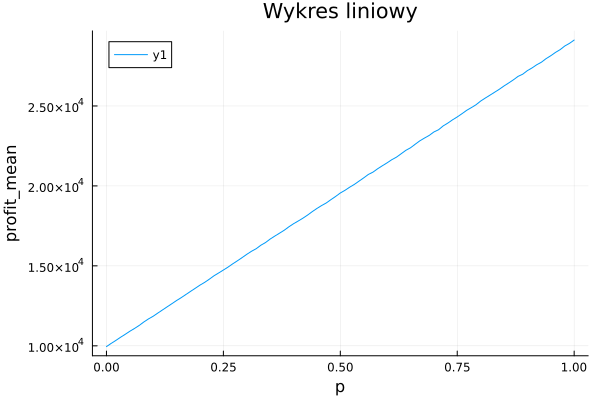

In [26]:
using Plots

plot(df[:, "p"], df[:, "profit_mean"], xlabel="p", ylabel="profit_mean", title="Wykres liniowy")


In [27]:
best_row = argmax(df.profit_mean)
df[best_row,:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
101,250,35,230,1000,1.0,29121.1,745.179,210.381,96.4999


In [28]:
using Random
using Distributions
using Statistics
# m - number of days
# s - reorder point
# S - target warehouse volume
function simulateOneRun(m, s, S;
    h = 0.1, #storage cost
    c = 4.0, #unit profit
    p = 0.50, #probability of delivery
    K = 100, # fixed order cost
    k = 1.0, # variable order cost
    init_S = 100, #initial warehouse level
    average_demand = 20)
    Xⱼ = init_S
    local Yj
    profit = 0.0
    lost_orders = 0.0
    warehouse_levels = Int[]
    #pois = Distributions.Poisson(average_demand)
    normal=Distributions.Normal(20,5)
    for day in 1:m
        if Xⱼ < s  # reorder point  #100 < 5 
            if rand() < p
                profit -= K + (S-Xⱼ)*k
                Xⱼ = S
            end
        end
        push!(warehouse_levels, Xⱼ)
        #demand = rand(pois)
        demand = round.(Int, rand(normal))
        sales = min(Xⱼ, demand) #(stan_magazynu, popyt_w_dniu )
        Xⱼ -= sales
        @assert Xⱼ >= 0
        lost_order = demand - sales # failed to provide  
        @assert lost_order >= 0 
        profit += sales*c - (Xⱼ-sales)*h  # storage costs
        lost_orders += lost_order
        #koszt_jednostkowy_Stock_outu to wtedy bez wag 
        # one_obj = 0.75 * profit + 0.25 * lost_orders * koszt_jednostkowy_Stock_outu 
        # wtedy kiedy wybieramy jedna opcje np logistyke
    end
    
    (profit=profit, lost_orders=lost_orders,
        warehouse_levels=warehouse_levels) #,one_obj
end

simulateOneRun (generic function with 2 methods)

In [29]:
function run_sims(m,s,S,N)
    df = DataFrame(simulateOneRun(m,s,S) for n in 1:N)
    (
        m=m,
        s=s,
        S=S,
        N=N,
        profit_mean = mean(df.profit),
        profit_std = std(df.profit),
        lost_mean = mean(df.lost_orders),
        lost_std = std(df.lost_orders)
    )
end

run_sims (generic function with 3 methods)

In [30]:
using Random
Random.seed!(0)
df = DataFrame(run_sims(250,30,250,1000))

LoadError: ArgumentError: 'NamedTuple{(:m, :s, :S, :N, :profit_mean, :profit_std, :lost_mean, :lost_std), Tuple{Int64, Int64, Int64, Int64, Float64, Float64, Float64, Float64}}' iterates 'Int64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

In [31]:

Random.seed!(0)

# Base simulation
df_base = DataFrame(run_sims(250, 30, 250, 1000))

# # Simulation with 5% increase in unit profit
# df_inc_c = DataFrame(run_sims(250,30,250,1000,c=4.2))

# # Simulation with 5% increase in hourly wage
# df_inc_wage = DataFrame(run_sims(250,30,250,1000,h=0.105))

# # Check R.O. for base simulation
# ro_base = round

LoadError: ArgumentError: 'NamedTuple{(:m, :s, :S, :N, :profit_mean, :profit_std, :lost_mean, :lost_std), Tuple{Int64, Int64, Int64, Int64, Float64, Float64, Float64, Float64}}' iterates 'Int64' values, which doesn't satisfy the Tables.jl `AbstractRow` interface

In [32]:
findall(<=(0), df.profit_mean)


Int64[]

In [33]:
df[66,:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
66,250,35,230,1000,0.65,22382.7,579.939,214.513,97.1942


In [34]:
df[[66, 74,82,90],:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64
1,250,35,230,1000,0.65,22382.7,579.939,214.513,97.1942
2,250,35,230,1000,0.73,23931.3,648.672,212.922,98.323
3,250,35,230,1000,0.81,25494.5,627.214,207.375,96.3676
4,250,35,230,1000,0.89,26986.2,702.371,208.06,98.825


In [35]:
df[findall(<=(-500), df.profit_mean),:]

Row,m,s,S,N,p,profit_mean,profit_std,lost_mean,lost_std
,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64


In [36]:
more500 = findall(>(-500), df.profit_mean)

101-element Vector{Int64}:
   1
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
   ⋮
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
 100
 101

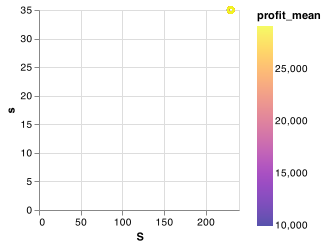

In [37]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:profit_mean, scale={scheme=:plasma}})

# scatter(df.S[more500],
#         df.s[more500], 
#         c=df.profit_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Profits")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()

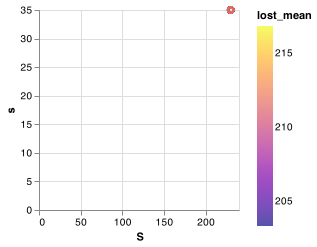

In [38]:
# using PyPlot
# using PyCall 

using VegaLite
df |> @vlplot(:point, x=:S, y=:s, color={:lost_mean, scale={scheme=:plasma}})

        # scatter(df.S[more500],
#         df.s[more500], 
#         c=df.lost_mean[more500] )
# xlabel("S - target wharehouse stock ")
# ylabel("s - reorder point")
# colorbar()
# title("Lost orders")

# scatter(df.S[Not(more500)],
#         df.s[Not(more500)], 
#         c="gray")
# show()
# savefig(raw"c:\temp\lost_orders.png")

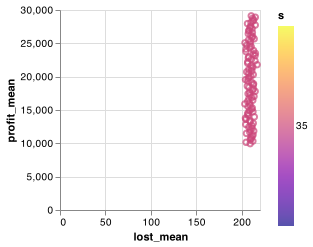

In [39]:
# w zaleznosci od wagi ktora kropka (lewy gorny rog) dla 1 wagi ta blizej lewej
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:s, scale={scheme=:plasma}})

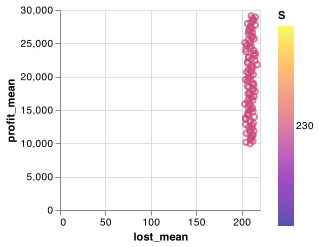

In [40]:
using VegaLite
df |> @vlplot(:point, x=:lost_mean, y=:profit_mean, color={:S, scale={scheme=:plasma}})

In [43]:
import Pkg; Pkg.add("Polynomials")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed MakieCore ─── v0.6.3
   Installed Observables ─ v0.5.4
   Installed Polynomials ─ v3.2.8
    Updating `~/.julia/environments/v1.8/Project.toml`
  [f27b6e38] + Polynomials v3.2.8
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [20f20a25] + MakieCore v0.6.3
  [510215fc] + Observables v0.5.4
  [f27b6e38] + Polynomials v3.2.8
Precompiling project...
  ✓ Observables
  ✓ MakieCore
  ✓ Polynomials
  3 dependencies successfully precompiled in 7 seconds. 226 already precompiled.


In [44]:
using Polynomials
# s_range - przedział wartości dla parametru s
# S_range - przedział wartości dla parametru S
# n_runs - liczba powtórzeń dla każdej kombinacji s i S
function simulateMultiRuns(m, s_range, S_range, n_runs;
    h = 0.1,
    c = 4.0,
    p = 0.50,
    K = 100,
    k = 1.0,
    init_S = 100,
    average_demand = 20)
    
    results = Dict{Tuple{Float64,Float64}, Vector{NamedTuple{(:profit, :lost_orders, :warehouse_levels), Tuple{Float64, Float64, Vector{Int64}}}}}()
    
    for s in s_range
        for S in S_range
            runs = Vector{NamedTuple{(:profit, :lost_orders, :warehouse_levels), Tuple{Float64, Float64, Vector{Int64}}}}(undef, n_runs)
            for i in 1:n_runs
                runs[i] = simulateOneRun(m, s, S; h=h, c=c, p=p, K=K, k=k, init_S=init_S, average_demand=average_demand)
            end
            results[(s,S)] = runs
        end
    end
    
    return results
end

# Funkcja do obliczenia współczynników kierunkowych regresji liniowej dla każdej pary parametrów s i S.
# results - wyniki z funkcji simulateMultiRuns()
function linearRegression(results)
    s_range, S_range = keys(results)
    n_runs = length(results[(s_range, S_range)])
    profits = zeros(length(keys(results)), n_runs)
    
    for (i, (s, S)) in enumerate(keys(results))
        for j in 1:n_runs
            profits[i,j] = results[(s, S)][j].profit
        end
    end
    coeffs = zeros(length(s_range), length(S_range))
    for i in 1:length(s_range)
        coeffs[i,:] = polyfit(S_range, profits[i,:], 1)[1]
    end
    return coeffs
end


linearRegression (generic function with 1 method)

In [45]:
using Polynomials
s_range = 1:10
S_range = 100:110
results = simulateMultiRuns(30, s_range, S_range, 5)
print(results)
# print("---")
# print(keys(results))
# coeffs = linearRegression(results)
# using Plots
# heatmap(S_range, s_range, coeffs', xlabel="S", ylabel="s", title="Współczynniki kierunkowe regresji")


Dict{Tuple{Float64, Float64}, Vector{NamedTuple{(:profit, :lost_orders, :warehouse_levels), Tuple{Float64, Float64, Vector{Int64}}}}}((1.0, 109.0) => [(profit = 1175.8999999999999, lost_orders = 81.0, warehouse_levels = [100, 76, 58, 48, 29, 14, 0, 109, 85, 64, 43, 29, 13, 109, 90, 82, 57, 31, 15, 0, 109, 93, 68, 54, 32, 16, 109, 81, 63, 44]), (profit = 948.2000000000002, lost_orders = 113.0, warehouse_levels = [100, 71, 46, 26, 15, 0, 109, 91, 75, 48, 27, 9, 0, 0, 109, 91, 62, 48, 36, 10, 0, 109, 94, 74, 58, 44, 30, 24, 109, 89]), (profit = 1134.6999999999996, lost_orders = 119.0, warehouse_levels = [100, 82, 58, 35, 11, 109, 84, 58, 38, 12, 0, 109, 91, 70, 46, 33, 7, 0, 109, 91, 69, 43, 25, 16, 0, 0, 109, 80, 61, 41]), (profit = 925.6999999999999, lost_orders = 117.0, warehouse_levels = [100, 90, 65, 43, 24, 0, 109, 92, 72, 50, 29, 15, 109, 93, 67, 49, 30, 5, 0, 0, 0, 109, 91, 69, 53, 39, 15, 0, 109, 92]), (profit = 1248.9, lost_orders = 86.0, warehouse_levels = [100, 68, 48, 27, 18,

[100, 83, 65, 37, 11, 109, 86, 75, 58, 35, 16, 0, 109, 90, 69, 55, 31, 14, 0, 0, 109, 90, 79, 48, 17, 3, 0, 109, 88, 65]), (profit = 996.6999999999999, lost_orders = 111.0, warehouse_levels = [100, 85, 60, 33, 8, 0, 109, 95, 84, 68, 53, 36, 18, 0, 109, 96, 75, 58, 28, 7, 0, 0, 109, 97, 74, 53, 39, 19, 109, 85]), (profit = 1185.3000000000002, lost_orders = 62.0, warehouse_levels = [100, 73, 57, 50, 38, 16, 109, 94, 75, 53, 40, 27, 109, 91, 68, 50, 31, 15, 0, 109, 89, 59, 39, 20, 0, 109, 87, 72, 57, 36]), (profit = 921.5, lost_orders = 142.0, warehouse_levels = [100, 78, 54, 39, 11, 109, 87, 68, 45, 26, 9, 0, 109, 83, 64, 47, 34, 7, 109, 91, 59, 44, 20, 0, 0, 0, 0, 0, 109, 91]), (profit = 1169.3000000000002, lost_orders = 69.0, warehouse_levels = [100, 78, 69, 45, 31, 13, 109, 90, 70, 57, 30, 9, 109, 86, 66, 54, 39, 16, 0, 109, 82, 73, 56, 45, 20, 3, 109, 87, 58, 32])], (8.0, 104.0) => [(profit = 1109.1000000000001, lost_orders = 80.0, warehouse_levels = [100, 73, 53, 37, 13, 0, 104, 87,

, 85, 71, 53, 29, 16, 103, 78, 63, 44, 21, 103, 83, 70, 48, 21, 1, 0, 103, 85, 66, 46, 21, 103, 83, 55, 39, 16, 0, 103]), (profit = 1191.1, lost_orders = 11.0, warehouse_levels = [100, 80, 63, 53, 29, 6, 103, 86, 68, 45, 25, 103, 84, 62, 43, 24, 103, 80, 61, 39, 17, 7, 103, 84, 66, 45, 33, 103, 80, 66]), (profit = 957.3000000000001, lost_orders = 94.0, warehouse_levels = [100, 85, 74, 62, 44, 20, 103, 87, 64, 37, 16, 103, 81, 59, 39, 23, 6, 0, 0, 0, 0, 103, 89, 66, 49, 34, 16, 103, 87, 53])], (3.0, 104.0) => [(profit = 876.5999999999999, lost_orders = 123.0, warehouse_levels = [100, 81, 59, 45, 24, 10, 104, 85, 69, 47, 26, 3, 104, 88, 71, 46, 24, 0, 0, 0, 0, 104, 88, 68, 51, 33, 20, 13, 104, 87]), (profit = 1198.4, lost_orders = 131.0, warehouse_levels = [100, 88, 67, 37, 8, 0, 104, 85, 55, 32, 12, 0, 0, 104, 80, 66, 37, 15, 0, 104, 77, 62, 50, 23, 104, 86, 64, 45, 23, 0]), (profit = 877.8000000000001, lost_orders = 149.0, warehouse_levels = [100, 85, 65, 37, 23, 1, 0, 104, 87, 77, 60,

133.0, warehouse_levels = [100, 76, 55, 34, 13, 0, 103, 75, 66, 38, 7, 103, 82, 57, 39, 25, 11, 103, 90, 71, 52, 29, 23, 7, 0, 0, 0, 103, 90, 71])], (1.0, 100.0) => [(profit = 1077.2, lost_orders = 117.0, warehouse_levels = [100, 80, 59, 31, 7, 0, 0, 100, 83, 60, 41, 21, 1, 100, 80, 66, 42, 26, 15, 100, 77, 57, 36, 18, 1, 0, 100, 80, 57, 34]), (profit = 1084.3000000000002, lost_orders = 158.0, warehouse_levels = [100, 75, 59, 27, 10, 0, 0, 100, 83, 64, 35, 14, 100, 76, 56, 41, 16, 0, 100, 82, 59, 33, 16, 0, 0, 100, 82, 53, 36, 26]), (profit = 1144.8, lost_orders = 89.0, warehouse_levels = [100, 83, 66, 40, 18, 100, 73, 58, 29, 16, 0, 100, 89, 73, 53, 35, 15, 0, 100, 77, 57, 39, 22, 1, 100, 81, 56, 44, 22, 5]), (profit = 828.7000000000003, lost_orders = 127.0, warehouse_levels = [100, 78, 59, 43, 31, 14, 100, 82, 64, 48, 28, 6, 100, 72, 54, 39, 26, 2, 100, 92, 78, 61, 42, 18, 0, 0, 0, 0, 0, 100]), (profit = 881.1, lost_orders = 156.0, warehouse_levels = [100, 69, 61, 46, 31, 19, 100, 77

 72, 50, 39, 15, 0, 110, 89, 70, 51, 32, 10, 110, 88, 69, 52, 33, 2, 110, 84, 62, 39, 22, 10, 0, 110, 92, 76, 54])], (6.0, 104.0) => [(profit = 1156.2999999999997, lost_orders = 87.0, warehouse_levels = [100, 74, 43, 17, 104, 79, 59, 49, 31, 5, 104, 97, 80, 55, 21, 0, 0, 0, 104, 86, 58, 40, 19, 104, 84, 65, 48, 24, 104, 81]), (profit = 1083.1, lost_orders = 76.0, warehouse_levels = [100, 77, 66, 41, 26, 7, 104, 83, 63, 44, 32, 18, 0, 0, 0, 104, 80, 61, 41, 29, 9, 104, 77, 60, 39, 22, 104, 82, 65, 51]), (profit = 1168.3000000000002, lost_orders = 66.0, warehouse_levels = [100, 76, 63, 37, 26, 8, 104, 77, 55, 37, 15, 104, 88, 60, 35, 15, 104, 87, 64, 51, 32, 16, 104, 87, 79, 66, 46, 29, 4, 0]), (profit = 1014.0999999999998, lost_orders = 113.0, warehouse_levels = [100, 93, 69, 52, 31, 15, 104, 83, 61, 38, 9, 0, 0, 0, 0, 0, 104, 89, 71, 44, 20, 6, 104, 88, 64, 44, 29, 104, 85, 66]), (profit = 1158.2, lost_orders = 122.0, warehouse_levels = [100, 83, 63, 50, 31, 11, 104, 85, 57, 27, 8, 0, 

1174.5999999999997, lost_orders = 89.0, warehouse_levels = [100, 80, 59, 44, 23, 2, 0, 104, 86, 72, 48, 27, 6, 104, 86, 68, 49, 27, 4, 104, 83, 67, 48, 29, 8, 104, 80, 63, 41, 24]), (profit = 965.4000000000001, lost_orders = 119.0, warehouse_levels = [100, 90, 69, 54, 39, 18, 104, 91, 75, 49, 28, 7, 0, 104, 90, 77, 64, 56, 38, 12, 0, 0, 0, 104, 89, 73, 45, 29, 20, 5]), (profit = 960.6999999999998, lost_orders = 167.0, warehouse_levels = [100, 74, 52, 32, 10, 0, 104, 78, 60, 51, 26, 4, 0, 104, 78, 58, 34, 19, 8, 0, 0, 0, 104, 79, 59, 46, 23, 0, 104, 78])], (1.0, 103.0) => [(profit = 1111.0, lost_orders = 81.0, warehouse_levels = [100, 82, 56, 30, 11, 103, 81, 58, 38, 18, 1, 103, 83, 61, 33, 17, 103, 83, 69, 41, 27, 3, 103, 81, 59, 30, 6, 0, 103, 89]), (profit = 1049.6, lost_orders = 87.0, warehouse_levels = [100, 81, 66, 45, 16, 2, 103, 93, 88, 65, 40, 22, 4, 103, 83, 60, 38, 8, 0, 0, 103, 84, 64, 34, 12, 103, 83, 68, 59, 43]), (profit = 1187.1000000000001, lost_orders = 123.0, warehous

1000.1, lost_orders = 125.0, warehouse_levels = [100, 74, 66, 50, 18, 0, 108, 90, 83, 58, 39, 20, 7, 0, 108, 90, 79, 55, 39, 20, 3, 108, 94, 79, 69, 56, 41, 13, 0, 0])], (2.0, 106.0) => [(profit = 1026.0, lost_orders = 73.0, warehouse_levels = [100, 86, 64, 49, 29, 10, 106, 84, 60, 52, 32, 19, 3, 106, 82, 68, 47, 28, 6, 106, 94, 82, 58, 37, 18, 0, 106, 88, 68, 56]), (profit = 1033.1999999999998, lost_orders = 95.0, warehouse_levels = [100, 88, 74, 55, 33, 17, 0, 0, 0, 106, 80, 56, 40, 24, 106, 77, 59, 48, 28, 4, 0, 106, 96, 84, 62, 47, 19, 106, 89, 68]), (profit = 1147.0000000000005, lost_orders = 73.0, warehouse_levels = [100, 83, 65, 44, 26, 3, 106, 81, 60, 42, 19, 0, 106, 81, 60, 48, 21, 106, 88, 64, 49, 27, 0, 106, 75, 45, 33, 17, 106, 89]), (profit = 1007.2, lost_orders = 183.0, warehouse_levels = [100, 72, 49, 37, 7, 106, 84, 71, 51, 43, 21, 0, 106, 85, 66, 45, 28, 14, 2, 0, 0, 0, 0, 0, 0, 106, 88, 66, 43, 14]), (profit = 1221.9, lost_orders = 90.0, warehouse_levels = [100, 79, 4

0, 0, 0, 103, 85, 65, 47, 23, 9, 0, 0, 103, 96, 75, 57, 41, 16, 0, 103, 85, 74, 47, 24, 5, 0]), (profit = 979.7000000000004, lost_orders = 119.0, warehouse_levels = [100, 80, 61, 43, 25, 2, 103, 79, 62, 44, 19, 103, 86, 69, 52, 35, 16, 0, 0, 0, 0, 103, 81, 63, 51, 32, 13, 103, 88, 68]), (profit = 1025.8999999999999, lost_orders = 70.0, warehouse_levels = [100, 82, 64, 48, 21, 0, 0, 103, 84, 61, 48, 21, 103, 78, 65, 44, 26, 9, 103, 78, 53, 31, 16, 103, 90, 78, 67, 51, 25, 103]), (profit = 1188.8999999999999, lost_orders = 105.0, warehouse_levels = [100, 72, 49, 21, 5, 0, 0, 0, 103, 78, 56, 44, 21, 103, 77, 56, 32, 8, 103, 78, 62, 44, 29, 13, 103, 82, 70, 46, 31, 9])], (9.0, 106.0) => [(profit = 1019.1000000000004, lost_orders = 99.0, warehouse_levels = [100, 84, 60, 43, 28, 17, 0, 0, 106, 89, 72, 56, 35, 12, 106, 89, 72, 44, 19, 0, 0, 106, 90, 77, 50, 28, 7, 106, 85, 64]), (profit = 990.7000000000003, lost_orders = 137.0, warehouse_levels = [100, 84, 68, 44, 28, 12, 0, 0, 0, 106, 77, 63

lost_orders = 123.0, warehouse_levels = [100, 81, 59, 28, 8, 0, 103, 78, 53, 31, 8, 0, 0, 103, 85, 64, 43, 17, 0, 103, 97, 82, 68, 43, 31, 9, 103, 82, 68, 49]), (profit = 960.6999999999997, lost_orders = 175.0, warehouse_levels = [100, 81, 60, 48, 29, 103, 86, 70, 45, 32, 14, 0, 0, 0, 103, 79, 65, 46, 24, 4, 0, 0, 0, 0, 103, 84, 65, 46, 26, 8])], (3.0, 110.0) => [(profit = 875.2999999999998, lost_orders = 103.0, warehouse_levels = [100, 84, 73, 56, 32, 12, 110, 98, 80, 59, 48, 27, 110, 94, 76, 59, 40, 32, 12, 110, 87, 69, 55, 33, 17, 0, 0, 0, 0, 110]), (profit = 1034.8, lost_orders = 163.0, warehouse_levels = [100, 89, 73, 60, 50, 30, 15, 0, 0, 0, 0, 110, 88, 70, 49, 34, 17, 0, 0, 110, 86, 59, 33, 7, 110, 97, 64, 40, 20, 1]), (profit = 1185.4, lost_orders = 106.0, warehouse_levels = [100, 77, 50, 34, 10, 110, 86, 65, 44, 20, 0, 0, 110, 87, 63, 36, 15, 3, 110, 85, 69, 51, 24, 4, 0, 110, 88, 77, 60, 40]), (profit = 816.6999999999999, lost_orders = 222.0, warehouse_levels = [100, 77, 53, 

[100, 86, 70, 48, 31, 18, 104, 85, 70, 45, 31, 104, 77, 60, 40, 31, 14, 104, 92, 80, 62, 36, 21, 104, 77, 54, 35, 10, 0, 104]), (profit = 994.5999999999999, lost_orders = 198.0, warehouse_levels = [100, 75, 48, 35, 15, 0, 0, 0, 0, 0, 104, 81, 58, 35, 18, 0, 104, 84, 67, 47, 33, 8, 104, 80, 63, 47, 23, 9, 0, 0]), (profit = 1177.4999999999998, lost_orders = 45.0, warehouse_levels = [100, 71, 45, 24, 104, 85, 56, 38, 21, 104, 84, 57, 35, 12, 0, 104, 83, 59, 39, 26, 19, 104, 86, 75, 53, 36, 23, 104, 86, 70])])

Przeprowadź Analizę wrażliwości: zmiana parametrów a rozwiązanie optymalne (RO)
– czy zmiana parametru (np.wzrost ceny produktu o 5%/ wzrost wynagrodzenia godzinowego ) spowoduje zmianę R.O., czy ciągle ono pozostanie takie samo? (5+)


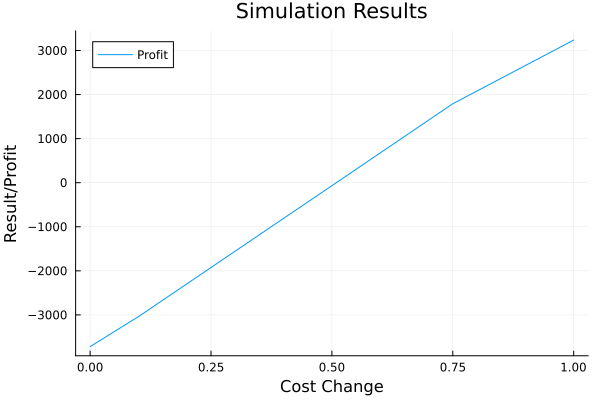

In [80]:
using Plots
gr()

# Parametry symulacji
m = 100
s = 20
S = 100
h = 0.1
c = 4.0
p = 0.50
K = 100
k = 1.0
init_S = 100
average_demand = 20

# Inicjalizacja wyników symulacji
profits = zeros(Float64, 5)
lost_orders = zeros(Float64, 5)

# Symulacja i obliczenie wyników
for (i, wage_change) in enumerate([0, 0.1, 0.5, 0.75, 1.0])
    results = simulateOneRun(m, s, S, h=h, c=c*wage_change, p=p, K=K, k=k, init_S=init_S, average_demand=average_demand)
    profits[i] = results.profit
    lost_orders[i] = results.lost_orders
end

# Wykres zmiany wyniku w zależności od zmiany wynagrodzenia
plot([0, 0.1, 0.5, 0.75, 1.0], profits, label="Profit")
#plot!([0, 0.1, 0.5, 1.0], lost_orders, label="Lost Orders")
xlabel!("Cost Change")
ylabel!("Result/Profit")
title!("Simulation Results")


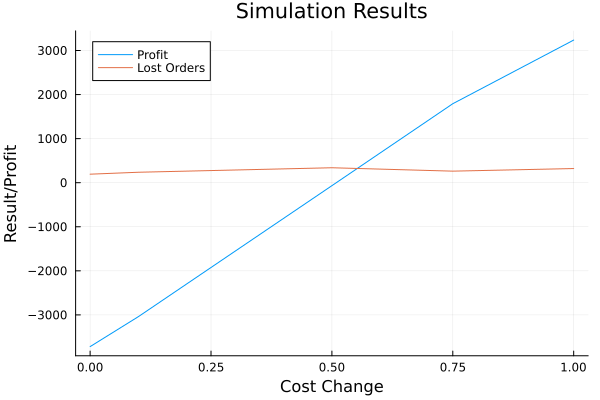

In [81]:
# Wykres zmiany wyniku w zależności od zmiany wynagrodzenia
plot([0, 0.1, 0.5, 0.75, 1.0], profits, label="Profit")
plot!([0, 0.1, 0.5, 0.75, 1.0], lost_orders, label="Lost Orders")
xlabel!("Cost Change")
ylabel!("Result/Profit")
title!("Simulation Results")

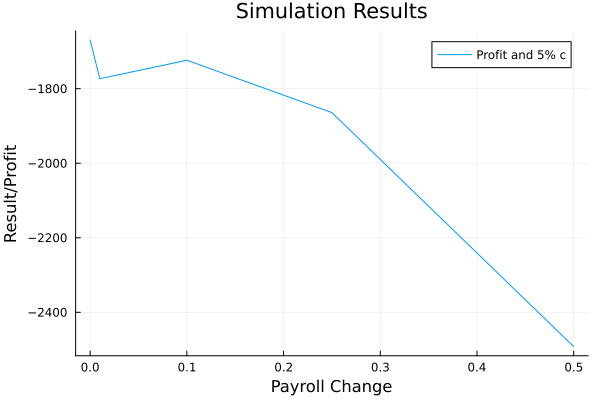

In [89]:
# Inicjalizacja wyników symulacji
profits_payroll_change_0_05_c = zeros(Float64, 5)
lost_orders_payroll_change_0_05_c = zeros(Float64, 5)
# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([0, 0.01, 0.1, 0.25, 0.5])
    results = simulateOneRun(m, s, S, h=h, c=c*0.05, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand)
    profits_payroll_change_0_05_c[i] = results.profit
    lost_orders_payroll_change_0_05_c[i] = results.lost_orders
end

# Wykres zmiany wyniku w zależności od zmiany wynagrodzenia
#plot([0, 0.1, 0.5, 0.75, 1.0], profits, label="Profit")
plot([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_05_c, label="Profit and 5% c")
#plot!([0, 0.1, 0.5, 0.75, 1.0], profits_payroll_change_0_05_c, label="Profit and 0,05c")
xlabel!("Payroll Change")
ylabel!("Result/Profit")
title!("Simulation Results")


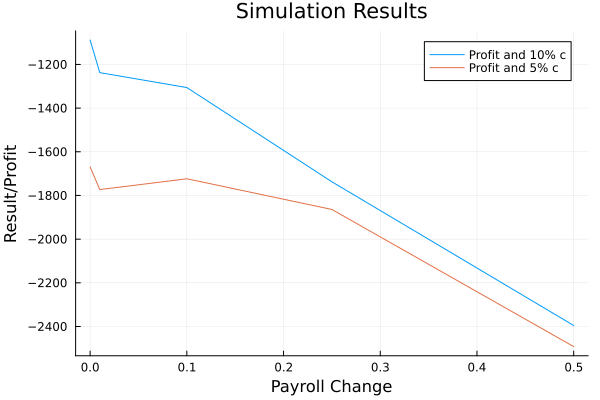

In [90]:
# Inicjalizacja wyników symulacji
profits_payroll_change_0_1_c = zeros(Float64, 5)
lost_orders_payroll_change_0_1_c = zeros(Float64, 5)
# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([0, 0.01, 0.1, 0.25, 0.5])
    results = simulateOneRun(m, s, S, h=h, c=c*0.1, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand)
    profits_payroll_change_0_1_c[i] = results.profit
    lost_orders_payroll_change_0_1_c[i] = results.lost_orders
end

# Wykres zmiany wyniku w zależności od zmiany wynagrodzenia
#plot([0, 0.1, 0.5, 0.75, 1.0], profits, label="Profit")
plot([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_1_c, label="Profit and 10% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_05_c, label="Profit and 5% c")
xlabel!("Payroll Change")
ylabel!("Result/Profit")
title!("Simulation Results")


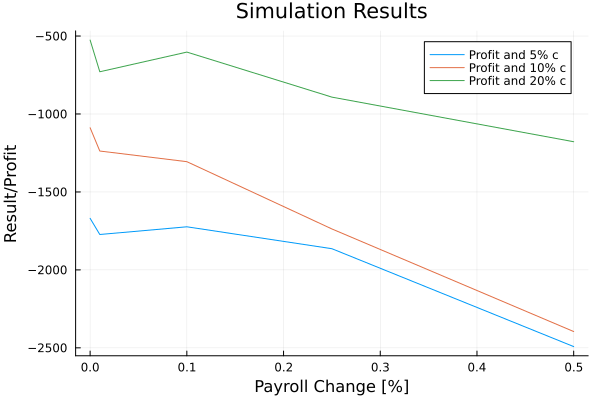

In [91]:
# Inicjalizacja wyników symulacji
profits_payroll_change_0_2_c = zeros(Float64, 5)
lost_orders_payroll_change_0_2_c = zeros(Float64, 5)
# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([0, 0.01, 0.1, 0.25, 0.5])
    results = simulateOneRun(m, s, S, h=h, c=c*0.2, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand)
    profits_payroll_change_0_2_c[i] = results.profit
    lost_orders_payroll_change_0_2_c[i] = results.lost_orders
end

# Wykres zmiany wyniku w zależności od zmiany wynagrodzenia
#plot([0, 0.1, 0.5, 0.75, 1.0], profits, label="Profit")
plot([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_05_c, label="Profit and 5% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_1_c, label="Profit and 10% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_2_c, label="Profit and 20% c")
xlabel!("Payroll Change [%]")
ylabel!("Result/Profit")
title!("Simulation Results")

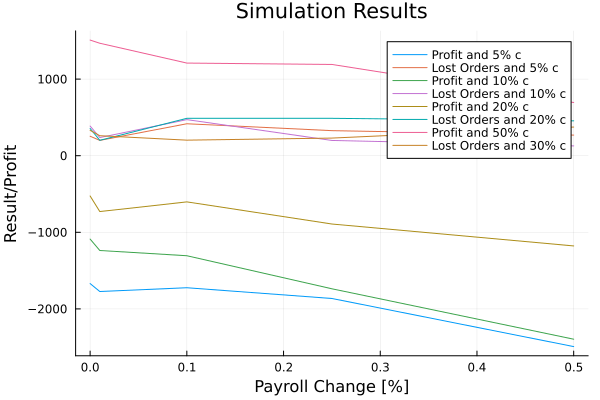

In [93]:
# Inicjalizacja wyników symulacji
profits_payroll_change_0_5_c = zeros(Float64, 5)
lost_orders_payroll_change_0_5_c = zeros(Float64, 5)
# Symulacja i obliczenie wyników
for (i, payroll_change) in enumerate([0, 0.01, 0.1, 0.25, 0.5])
    results = simulateOneRun(m, s, S, h=h, c=c*0.5, p=p, K=K, k=k*payroll_change, init_S=init_S, average_demand=average_demand)
    profits_payroll_change_0_5_c[i] = results.profit
    lost_orders_payroll_change_0_5_c[i] = results.lost_orders
end

# Wykres zmiany wyniku w zależności od zmiany wynagrodzenia
#plot([0, 0.1, 0.5, 0.75, 1.0], profits, label="Profit")
plot([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_05_c, label="Profit and 5% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_05_c, label="Lost Orders and 5% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_1_c, label="Profit and 10% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_1_c, label="Lost Orders and 10% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_2_c, label="Profit and 20% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_2_c, label="Lost Orders and 20% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], profits_payroll_change_0_5_c, label="Profit and 50% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_5_c, label="Lost Orders and 30% c")
xlabel!("Payroll Change [%]")
ylabel!("Result/Profit")
title!("Simulation Results")

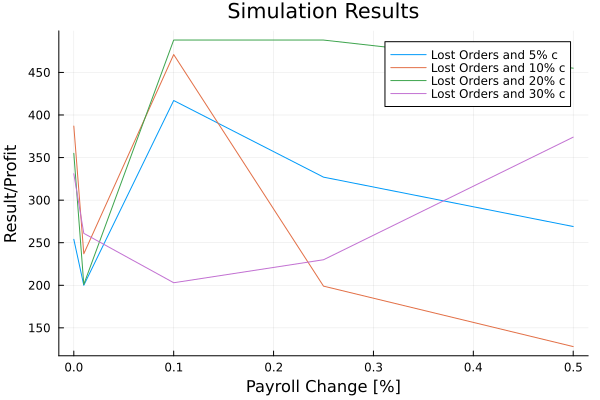

In [95]:

# Wykres zmiany wyniku w zależności od zmiany wynagrodzenia
#plot([0, 0.1, 0.5, 0.75, 1.0], profits, label="Profit")
plot([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_05_c, label="Lost Orders and 5% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_1_c, label="Lost Orders and 10% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_2_c, label="Lost Orders and 20% c")
plot!([0, 0.01, 0.1, 0.25, 0.5], lost_orders_payroll_change_0_5_c, label="Lost Orders and 30% c")
xlabel!("Payroll Change [%]")
ylabel!("Result/Profit")
title!("Simulation Results")